Check the GPU, make sure it is Tesla P100-PCIE or V100-SXM2

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Tue Jul 26 04:20:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Connect Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
#!pip install -U albumentations>=0.3.0 --user 
!pip install opencv-python-headless==4.5.4.60
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
!pip install -U --pre segmentation-models --user
# https://github.com/keras-team/keras/issues/14265#issuecomment-720376773
!pip install h5py==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47.6 MB 1.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-yh79th_f
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-yh79th_f
  Created wheel for albumentations: filename=albumentations-1.2.1-py3-none-any.whl size=116794 sha256=3d9979f4bc824bf335e19183270d9f52b702fa2b3e9d25b30688f1693695e594
  Stored in directory: /tmp/pip-ephem-wheel-cache-09yp6sh0/wheels/63/11/1a/c77caf3ae9b9b6d57b3ee5e6a41a50f3bc12c66a70f6b90bf0
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Looking in indexes: https://pypi.org/simple, https:/

# Restart Runtime then execute the following cells

##Import libraries
#### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [1]:
%tensorflow_version 1.x
# 1.15.2 / 2.3.1
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.
1.15.2
2.3.1


Using TensorFlow backend.


In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

import albumentations as A
import segmentation_models as sm

from PIL import Image
from skimage import io
import random as rng

Segmentation Models: using `keras` framework.


# Loading dataset

 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 512 pixels height and 512 pixels width.

**The mask image is an 1 channel png image with classes as its pixel value**

In [4]:
!wget --no-check-certificate \
    https://djangocolab3.blob.core.windows.net/aidatacolab2/chimei_2v_568_68.zip \
    -O chimei_2v_568_68.zip

--2022-07-26 04:22:01--  https://djangocolab3.blob.core.windows.net/aidatacolab2/chimei_2v_568_68.zip
Resolving djangocolab3.blob.core.windows.net (djangocolab3.blob.core.windows.net)... 20.150.13.4
Connecting to djangocolab3.blob.core.windows.net (djangocolab3.blob.core.windows.net)|20.150.13.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106590051 (102M) [application/zip]
Saving to: ‘chimei_2v_568_68.zip’

chimei_2v_568_68.zi 100%[===================>] 101.65M  10.6MB/s    in 9.0s    

2022-07-26 04:22:10 (11.2 MB/s) - ‘chimei_2v_568_68.zip’ saved [106590051/106590051]



In [5]:
!unzip -q chimei_2v_568_68.zip
!rm -r __MACOSX

## Delete hidden files from Mac

In [6]:
f_t_c = "chimei_2v_568_68"

for i in os.listdir(os.path.join(f_t_c, "train")):
  if i.startswith('.'):
    print(i)
    os.remove(os.path.join(f_t_c, "train", i))
for i in os.listdir(os.path.join(f_t_c, "trainannot")):
  if i.startswith('.'):
    print(i)
    os.remove(os.path.join(f_t_c, "trainannot", i))
for i in os.listdir(os.path.join(f_t_c, "val")):
  if i.startswith('.'):
    print(i)
    os.remove(os.path.join(f_t_c, "val", i))
for i in os.listdir(os.path.join(f_t_c, "valannot")):
  if i.startswith('.'):
    print(i)
    os.remove(os.path.join(f_t_c, "valannot", i))

In [7]:
!mkdir CamVid
!mv chimei_2v_568_68/* CamVid/

!mkdir CamVid/test/
!mkdir CamVid/testannot/

mkdir: cannot create directory ‘CamVid/test/’: File exists
mkdir: cannot create directory ‘CamVid/testannot/’: File exists


In [8]:
train_folder = 'CamVid/train/'
train_L_folder = 'CamVid/trainannot/'
print("total images in train folder: ", len(os.listdir(train_folder)))
print("total images in train_L folder: ", len(os.listdir(train_L_folder)))

val_folder = 'CamVid/val/'
val_L_folder = 'CamVid/valannot/'
print("total images in val folder: ", len(os.listdir(val_folder)))
print("total images in val_L folder: ", len(os.listdir(val_L_folder)))

test_folder = 'CamVid/test/'
test_L_folder = 'CamVid/testannot/'
print("total images in test folder: ", len(os.listdir(test_folder)))
print("total images in test_L folder: ", len(os.listdir(test_L_folder)))

total images in train folder:  568
total images in train_L folder:  568
total images in val folder:  68
total images in val_L folder:  68
total images in test folder:  0
total images in test_L folder:  0


In [9]:
DATA_DIR = './CamVid/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

# Dataloader and utility functions 

In [10]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(20, 5)) #16,5
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        # plt.xticks([])
        # plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['bg', 'heart'] #, 'unlabelled'
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

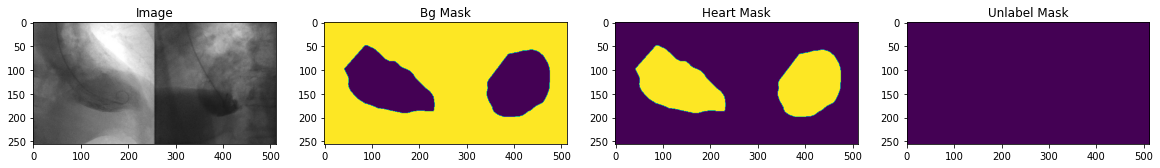

(256, 512, 3)


In [11]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['bg', 'heart'])

image, mask = dataset[24] # get some sample
visualize(
    image=image, 
    bg_mask=mask[..., 0].squeeze(),
    heart_mask=mask[..., 1].squeeze(),
    unlabel_mask=mask[..., 2].squeeze()
)

print(mask.shape)

### Augmentations

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.

In [12]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        # A.HorizontalFlip(p=0.5),

        #A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=10, shift_limit=0, p=0.5, border_mode=0), # strong augmentation
        # A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=10, shift_limit=0, p=0.3, border_mode=0), # weak augmentation

        A.PadIfNeeded(min_height=256, min_width=512, always_apply=True, border_mode=0),
        A.RandomCrop(height=256, width=512, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        
        A.IAAPerspective(p=0.5), # strong augmentation
        # A.IAAPerspective(p=0.3), # weak augmentation

        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0, p=0.3), # strong augmentation

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9, # strong augmentation
            # p=0.3, # weak augmentation
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9, # strong augmentation
            # p=0.3, # weak augmentation
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9, # strong augmentation
            # p=0.3, # weak augmentation
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.RandomCrop(height=256, width=512, always_apply=True),
        A.PadIfNeeded(min_height=256, min_width=512)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:263: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:386: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1615: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:233: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albument

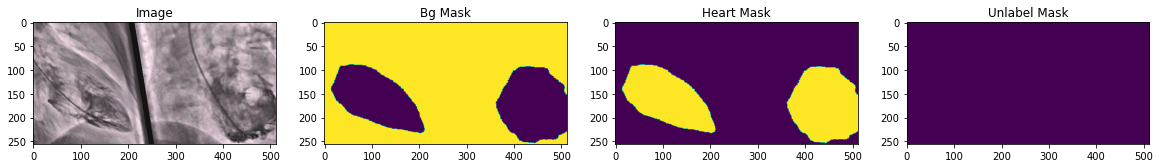

(256, 512, 3)


In [13]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['bg', 'heart'], augmentation=get_training_augmentation())

image, mask = dataset[11] # get some sample
visualize(
    image=image, 
    bg_mask=mask[..., 0].squeeze(),
    heart_mask=mask[..., 1].squeeze(),
    unlabel_mask=mask[..., 2].squeeze()
)

print(mask.shape)

# Segmentation model training

Setting manual: https://segmentation-models.readthedocs.io/en/latest/tutorial.html#models-and-backbones

In [14]:
BACKBONE = "mobilenetv2" # 'efficientnetb1' 'mobilenetv2'
BATCH_SIZE = 4 # 4 8
CLASSES = ['bg', 'heart']
LR = 0.00025 # 0.0001 0.00025 0.01
EPOCHS = 60 # 60

preprocess_input = sm.get_preprocessing(BACKBONE)

https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/models/unet.py

In [15]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

# create model
# decoder_filters=(256, 128, 64, 32, 16) (192, 96, 48, 24, 12) (128, 64, 32, 16, 8)
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, decoder_block_type='transpose', input_shape=(256, 512, 3), decoder_filters=(128, 64, 32, 16, 8))
# model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights=None)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/tensorflow-1.15.2/python3.7/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 1s 0us/step


In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 512, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 513, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 256, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 256, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

## Set loss and metrics

In [17]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss ['bg', 'heart', 'unlabelled']
# class_weights=np.array([0.5, 1, 0.01]) pixel 0-1 level 

# dice_loss = sm.losses.DiceLoss() #class_weights=np.array([0.5, 1, 0.01])
jaccard_loss = sm.losses.JaccardLoss(class_weights=np.array([0.2, 1, 0.01])) #class_weights=np.array([0.5, 1, 0.01]) 

focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
# ce_loss = sm.losses.BinaryCELoss() if n_classes == 1 else sm.losses.CategoricalCELoss() #class_weights=np.array([0.5, 1, 0.01]) 

# total_loss = dice_loss + (1 * focal_loss)
# total_loss = dice_loss + (1 * ce_loss)
total_loss = jaccard_loss + (1 * focal_loss)
# total_loss = jaccard_loss + (1 * ce_loss)
# total_loss = ce_loss

metrics = [sm.metrics.IOUScore(threshold=0.5, class_indexes=[1]), # , class_indexes=[1]
          #  sm.metrics.FScore(threshold=0.5, class_indexes=[1]), # , class_indexes=[1]
          #  sm.metrics.Precision(threshold=0.5), # , class_indexes=[1]
          #  sm.metrics.Recall(threshold=0.5, class_indexes=[1]) # , class_indexes=[1]
           ] 

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

## Load dataset

In [18]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 512, n_classes)

assert valid_dataloader[0][0].shape == (1, 256, 512, 3)
assert valid_dataloader[0][1].shape == (1, 256, 512, n_classes)

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:263: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:386: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1615: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:233: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albument

## Define callbacks for learning rate scheduling and best checkpoints saving

In [19]:
# def my_scheduler(epoch, lr):
#   if epoch < 31:
#     return lr
#   else:
#     return 0.00001 # lr * tf.math.exp(-0.1)

callbacks = [
    # monitor='val_iou_score', mode='max' # mode='min'
    keras.callbacks.ModelCheckpoint('drive/MyDrive/colab_data/chimei_2_views/checkpoints/UNet/UNET_568_1to100_jf_{epoch:02d}_{val_iou_score:.2f}_model.h5', save_weights_only=False, save_best_only=True, monitor='val_iou_score', mode='max'),
    keras.callbacks.ReduceLROnPlateau(patience=12, verbose=1), # patience=12, min_lr=0.00001
    # keras.callbacks.LearningRateScheduler(schedule=my_scheduler, verbose=1)
    keras.callbacks.CSVLogger('drive/MyDrive/colab_data/chimei_2_views/checkpoints/UNet/UNET_568_1to100_jf_model.csv')
]

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau  

## Train the model

In [20]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

model.save('drive/MyDrive/colab_data/chimei_2_views/checkpoints/UNet/UNET_568_1to60_jf_60_model')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/60
142/142 [==============================] - 42s 293ms/step - loss: 0.8482 - iou_score: 0.5121 - val_loss: 0.8318 - val_iou_score: 0.5422
Epoch 2/60
142/142 [==============================] - 26s 184ms/step - loss: 0.7063 - iou_score: 0.7967 - val_loss: 0.6793 - val_iou_score: 0.7671
Epoch 3/60
142/142 [==============================] - 26s 186ms/step - loss: 0.6848 - iou_score: 0.8240 - val_loss: 0.6769 - val_iou_score: 0.7742
Epoch 4/60
142/142 [==============================] - 27s 188ms/step - loss: 0.6743 - iou_score: 0.8421 - val_loss: 0.6712 - val_iou_score: 0.7709
Epoch 5/60
142/142 [==============================] - 28s 194ms/step - loss: 0.6680 - iou_score: 0.8540 - val_loss: 0.6677 - val_iou_score: 0.8187
Epoch 6/60
142/142 [==============================] - 26s 186ms/step - loss: 0.6645 - iou_score: 0.8604 - val_loss: 0.6668 - val_iou_score: 0.8283
Epoch 7/60
142/142 [===

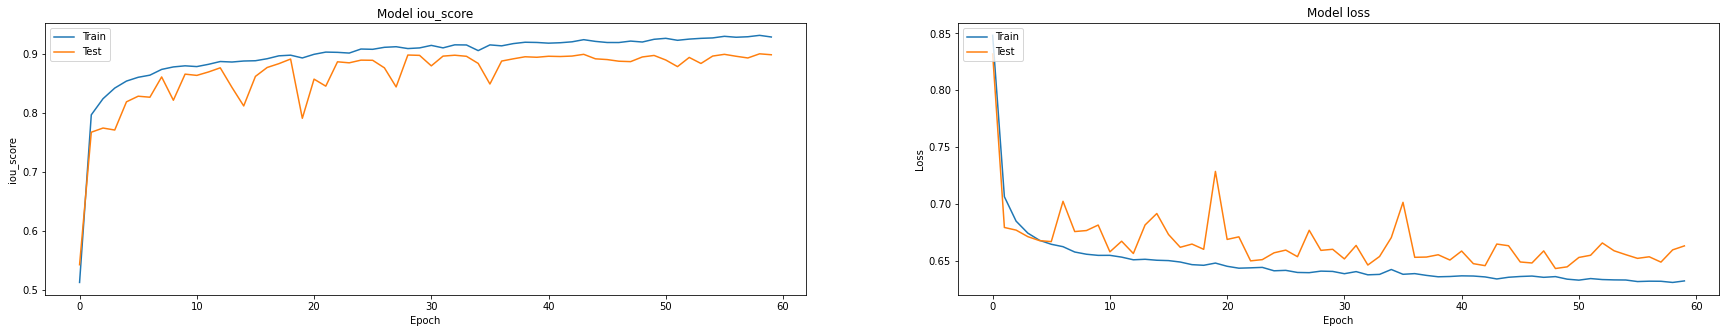

In [21]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model Evaluation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


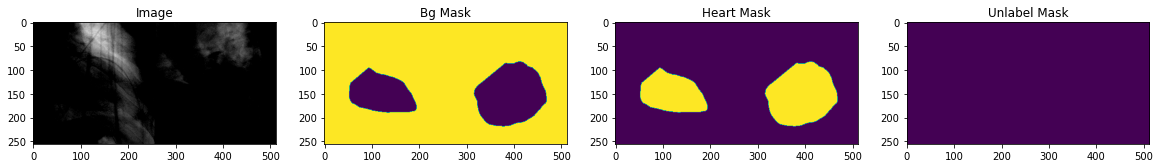

In [22]:
test_dataset = Dataset(
    x_valid_dir, # x_valid_dir,
    y_valid_dir, # y_valid_dir
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

image, mask = test_dataset[8] # get some sample
visualize(
    image=image, 
    bg_mask=mask[..., 0].squeeze(),
    heart_mask=mask[..., 1].squeeze(),
    unlabel_mask=mask[..., 2].squeeze()
)

##Load weights

In [23]:
# !wget https://djangocolab.blob.core.windows.net/aidatacolab2/UNET_1304_1to40_jf_40_0.97_model.h5
# model.load_weights('UNET_1304_1to40_jf_40_0.97_model.h5')

# load weights
model.load_weights('drive/MyDrive/colab_data/chimei_2_views/checkpoints/UNet/20220726_568_MobileNetV2_transpose_0.5/UNET_568_1to100_jf_59_0.90_model.h5') 
model.summary()

# load model
# model = keras.models.load_model('drive/MyDrive/colab_data/chimei_2_views/checkpoints/UNet/20220719_568_MobileNetV2_transpose/UNET_568_1to100_jf_60_0.90_model.h5', compile=False) 
# model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 512, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 513, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 256, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 256, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [24]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.4}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.4}".format(metric.__name__, value))

Loss: 0.6596
mean iou_score: 0.9002


## Save .h5 model file

In [ ]:
### save no weight model
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
# model.save("drive/MyDrive/colab_data/chimei_2_views/checkpoints/UNet/UNET_efficientnetb1_no_weight_model.h5")
# It can be used to reconstruct the model identically.
# model = keras.models.load_model("drive/MyDrive/colab_data/chimei_2_views/checkpoints/UNet/UNET_efficientnetb1_no_weight_model.h5")

### save trained model
# model.save("drive/MyDrive/colab_data/chimei_2_views/checkpoints/UNet/20211123_428_B1_ImageNet/UNET_4626_1to40_jf_26_0.92_model.h5")
# model = keras.models.load_model("drive/MyDrive/colab_data/chimei_2_views/checkpoints/UNet/20211123_428_B1_ImageNet/UNET_4626_1to40_jf_26_0.92_model.h5")

## Calculate IoU Score

calculate average score for all classes

In [25]:
total_test_images = len(os.listdir(val_folder)) # val_folder
total_labels = [0,1]
iou_threshold = 0.5

score_now = 0

for i in range(total_test_images):
    # get the predicted mask
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = np.squeeze(model.predict(image))
    pr_mask = np.round(pr_mask)
    # print(gt_mask.shape)
    # print(pr_mask.shape)

    # calculate IoU score of each class
    for j in total_labels:
      if np.sum(gt_mask[:,:,j]) == 0 and np.sum(pr_mask[:,:,j]) == 0:
        score_now = score_now + 1
      else:
        intersection = np.sum(gt_mask[:,:,j] * pr_mask[:,:,j])
        union = np.sum(gt_mask[:,:,j] + pr_mask[:,:,j]) - intersection
        iou = intersection / union
        if iou > iou_threshold:
          score_now = score_now + 1

print("total score:", score_now)
print("total test images:", total_test_images)
print("accuracy(IOU",iou_threshold,"):", round((score_now / total_test_images)/len(total_labels), 4))

total score: 136
total test images: 68
accuracy(IOU 0.5 ): 1.0


calculate average score for each class, full score is 1 per class.

In [ ]:
total_test_images = len(os.listdir(val_folder)) # val_folder
print("total test images:", total_test_images)
total_labels = [0,1]
iou_threshold = 0.5

for j in total_labels:
  score_now = 0
  GT_N = 0
  TP = 0
  for i in range(total_test_images):
      # get the predicted mask
      image, gt_mask = test_dataset[i]
      image = np.expand_dims(image, axis=0)
      pr_mask = np.squeeze(model.predict(image))
      pr_mask = np.round(pr_mask)

      # calculate IoU score of each class
      if np.sum(gt_mask[:,:,j]) == 0:
        GT_N  = GT_N  + 1
      if np.sum(gt_mask[:,:,j]) == 0 and np.sum(pr_mask[:,:,j]) == 0:
        score_now = score_now + 1
      else:
        intersection = np.sum(gt_mask[:,:,j] * pr_mask[:,:,j])
        union = np.sum(gt_mask[:,:,j] + pr_mask[:,:,j]) - intersection
        iou = intersection / union
        if iou > iou_threshold:
          score_now = score_now + 1
          TP = TP + 1
  # TP TN FP FN calculation
  TN = score_now - TP
  FP = GT_N - TN
  FN = (total_test_images - GT_N) - TP # GT_P - TP

  print(CLASSES[j],":")
  print("TP, TN, FP, FN:", TP, TN, FP, FN)
  print("sensitivity:", TP/(TP+FN))
  print("accuracy:", round(score_now / total_test_images, 4))
  print("*"*100)

total test images: 68
bg :
TP, TN, FP, FN: 68 0 0 0
sensitivity: 1.0
accuracy: 1.0
****************************************************************************************************
heart :
TP, TN, FP, FN: 68 0 0 0
sensitivity: 1.0
accuracy: 1.0
****************************************************************************************************


# Visualization of results on test dataset

In [26]:
def draw_color(input_image, mask_image):
    colors = [(0,0,0),      #bg
              (250,0,0),    #heart
              (0,0,0)]       #unlabel
    classes = ['bg', 'heart', 'unlabelled']
    out_image = np.zeros_like(input_image)
    #print("mask image shape is:", mask_image.shape)
    for i in range(len(classes)):
        class_mask = mask_image[...,i] # get the layer of class
        class_mask = np.stack((class_mask * colors[i][0], class_mask * colors[i][1], class_mask * colors[i][2]), axis=-1)
        out_image = out_image + class_mask
    
    out_image= out_image.astype(int) # make it int so plt.imshow can show rgb 0-255, float will show 0-1
    return out_image

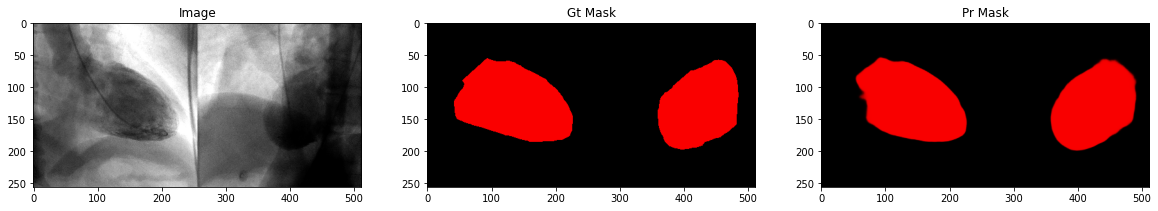

(1, 256, 512, 3)
(1, 256, 512, 3)


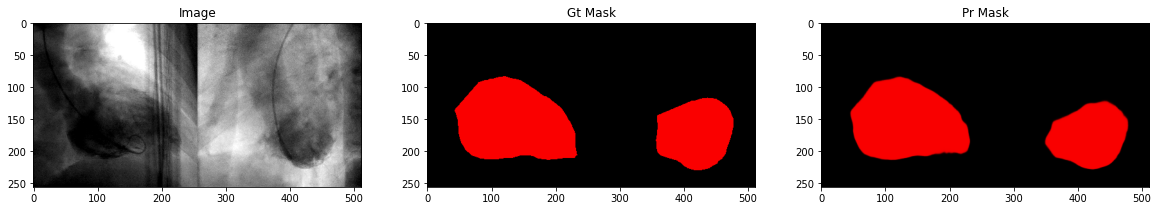

(1, 256, 512, 3)
(1, 256, 512, 3)


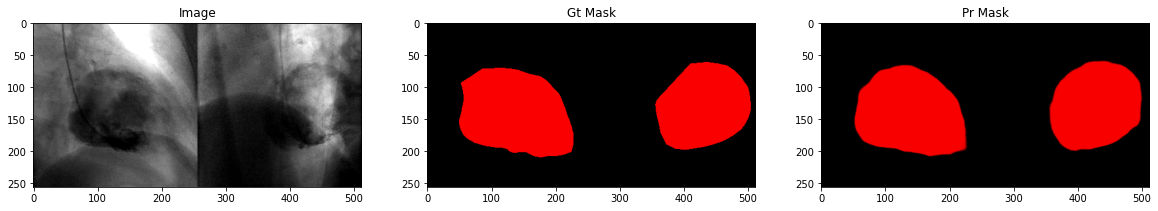

(1, 256, 512, 3)
(1, 256, 512, 3)


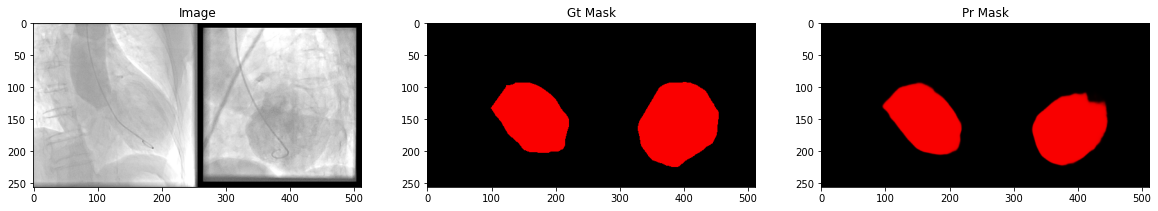

(1, 256, 512, 3)
(1, 256, 512, 3)


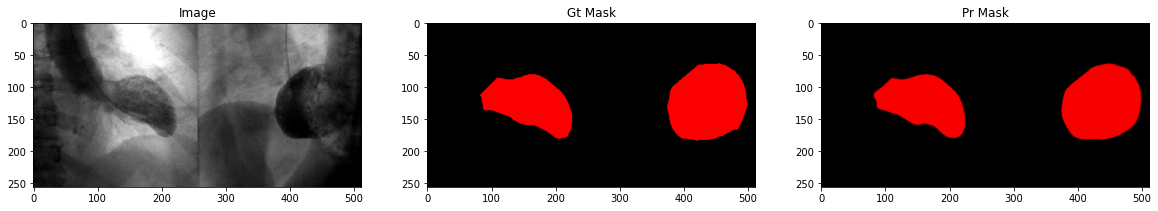

(1, 256, 512, 3)
(1, 256, 512, 3)


In [28]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    gt_mask = draw_color(image, gt_mask)
    pr_mask = draw_color(image, pr_mask)

    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )

    print(gt_mask.shape)
    print(pr_mask.shape)

# Test dataset predicted mask for submission

## Download test dataset

In [ ]:
!wget --no-check-certificate \
    https://djangocolab3.blob.core.windows.net/aidatacolab2/chimei_test_20210914.zip\
    -O chimei_test_20210914.zip

!unzip -q chimei_test_20210914.zip
!rm -r __MACOSX

# !unzip -q chimei_test_part.zip
# !rm -r __MACOSX

--2022-04-13 02:56:04--  https://djangocolab.blob.core.windows.net/aidatacolab2/chimei_test_20210914.zip
Resolving djangocolab.blob.core.windows.net (djangocolab.blob.core.windows.net)... 20.150.86.132
Connecting to djangocolab.blob.core.windows.net (djangocolab.blob.core.windows.net)|20.150.86.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1080884483 (1.0G) [application/zip]
Saving to: ‘chimei_test_20210914.zip’

chimei_test_2021091 100%[===================>]   1.01G  6.32MB/s    in 4m 1s   

2022-04-13 03:00:06 (4.28 MB/s) - ‘chimei_test_20210914.zip’ saved [1080884483/1080884483]



## Util for generating all predicted masks

In [ ]:
def save_color(pr_mask, pr_mask_path):
    colors = [(0,0,0),      #bg
              (250,0,0),    #heart
              (0,0,0)]       #unlabel

    height, width = pr_mask.shape[0], pr_mask.shape[1]
    img_mask = Image.new(mode = "RGB", size = (width, height))
    px = img_mask.load()

    for x in range(0,width):
        for y in range(0,height):
             px[x,y] = colors[pr_mask[y][x]]
      
    img_mask.save(pr_mask_path)


def visualize_test(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(6, 3)) #16,5
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        # plt.xticks([])
        # plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


def draw_combined_color(mask_image):
    colors = {0:0,      #bg 0
              1:250,    #diastole 1
              -1:100}    #systole -1

    out_image = np.zeros_like(mask_image)

    for k,v in colors.items():
        class_mask = (mask_image==k) # get the layer of class
        class_mask = class_mask * colors[k]
        out_image = out_image + class_mask
    
    out_image= out_image.astype(int) # make it int so plt.imshow can show rgb 0-255, float will show 0-1
    return out_image


def get_enclosing_circle(pr_mask, threshold=100):
    """
    input:
        pr_mask is numpy array with shape (width height)
        threshold max 255 default 100
    outputs:
        enclosing circle center and radius
    """
    colors = [0,      #bg
              250,    #heart
              0]      #unlabel

    height, width = pr_mask.shape[0], pr_mask.shape[1]
    img_mask = Image.new(mode = "L", size = (width, height))
    px = img_mask.load()

    for x in range(0,width):
        for y in range(0,height):
             px[x,y] = colors[pr_mask[y][x]]
        
    img_mask.save("enclosing.jpg")
    # cv2 process from here
    src = cv2.imread("enclosing.jpg")
    src_blur = cv2.blur(src, (3,3))
    # cv2.imwrite("enclosing_blur.jpg", src_blur)
    # Detect edges using Canny
    canny_output = cv2.Canny(src_blur, threshold, threshold * 2)
    # cv2.imwrite("enclosing_canny.jpg", canny_output)
    # Find contours
    contours, _ = cv2.findContours(canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Approximate contours to polygons + get bounding rects and circles
    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    centers = [None]*len(contours)
    radius = [None]*len(contours)
    for i, c in enumerate(contours):
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        centers[i], radius[i] = cv2.minEnclosingCircle(contours_poly[i])
    # draw result
    drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
    # Draw polygonal contour + bonding rects + circles
    temp_i = 0
    temp_r = 0
    for i in range(len(contours)):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        cv2.drawContours(drawing, contours_poly, i, color)
        cv2.circle(drawing, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2)
        # keep the biggest circle for output
        if int(radius[i]) > temp_r:
          temp_r = int(radius[i])
          temp_i = i
    # cv2.imwrite('enclosing_contours.jpg', drawing)
    return int(centers[temp_i][0]), int(centers[temp_i][1]), int(radius[temp_i])


def combine_2_images(width=256*2, height=256, testdata_folder="CamVid/test/"):
  # combine 2 view images and resize it to target size
  temp_image_list = [f for f in os.listdir("tmp_front") if not f.startswith('.')]
  temp_image_L_list = [f for f in os.listdir("tmp_lateral") if not f.startswith('.')]
  assert len(temp_image_list) == len(temp_image_L_list)
  print("combining", len(temp_image_list), "images")
  for i in range(len(temp_image_list)):
    # generate image
    img = cv2.imread(os.path.join("tmp_front", temp_image_list[i]))
    img_L = cv2.imread(os.path.join("tmp_lateral", temp_image_L_list[i]))
    vis = np.concatenate((img, img_L), axis=1)
    vis = cv2.resize(vis, (width,height), interpolation=cv2.INTER_NEAREST)
    cv2.imwrite(os.path.join(testdata_folder, temp_image_list[i].split('.')[0]+temp_image_L_list[i].split('.')[0].split('_')[-1]+'.png'), vis)


def find_max_min(testdata_folder="CamVid/test/", savedata_folder = "chimei_predicted/", 
                 width=256, height=256, skip_start=25, skip_end=25, min_threshold=20):
  """
  skip_start, skip_end can make sure developer well spread
  min_threshold can make sure developer not gone
  """
  testdatalist = os.listdir(testdata_folder)
  # sort the file name
  testdatalist.sort()
  total_images = len(testdatalist)
  print("total test images:", len(testdatalist))
  savedatalist = os.listdir(savedata_folder)
  print("total predicted images:", len(savedatalist))

  # original images dict
  test_dict = dict(enumerate(testdatalist))
  # count the pixel of heart
  heart_max = 0
  heart_min = width*height
  max_file = str()
  min_file = str()
  max_key = int()
  min_key = int()

  # get the max area image first
  for k,i in enumerate(testdatalist):
      if k > skip_start and k < total_images-skip_end:
        image = io.imread(os.path.join(testdata_folder, i)) # novel image
        # convert 1 channel to 3 channel if necessary
        if len(image.shape) == 2:
          image = np.stack((image,)*3, axis=-1)
        image = preprocess_input(image) # use the preprocessing input method based on the backbone you used
        image = np.expand_dims(image, axis = 0) # change the shape to (1, H, W)
        pr_mask = model.predict(image) 
        pr_mask = pr_mask.squeeze()
        pr_mask = np.argmax(pr_mask, axis = 2)
        save_color(pr_mask, savedata_folder + i)
        # print("complete ", savedata_folder + i)
        # crop front view image on the left side
        pr_mask = pr_mask[:,:256]
        # count the pixels of heart(label==1)
        heart = np.sum(pr_mask==1)
        if heart > heart_max:
          heart_max = heart
          max_file = i
          max_key = k

  # get the min area image, the min image should appear after max image
  for k,i in enumerate(testdatalist):
      if k > max_key and k < max_key+min_threshold:
        image = io.imread(os.path.join(testdata_folder, i)) # novel image
        # convert 1 channel to 3 channel if necessary
        if len(image.shape) == 2:
          image = np.stack((image,)*3, axis=-1)
        image = preprocess_input(image) # use the preprocessing input method based on the backbone you used
        image = np.expand_dims(image, axis = 0) # change the shape to (1 H, W)
        pr_mask = model.predict(image) 
        pr_mask = pr_mask.squeeze()
        pr_mask = np.argmax(pr_mask, axis = 2)
        # print("complete ", savedata_folder + i)
        # crop front view image on the left side
        pr_mask = pr_mask[:,:256]
        # count the pixels of heart(label==1)
        heart = np.sum(pr_mask==1)
        if heart < heart_min:
          heart_min = heart
          min_file = i
          min_key = k

  # check the results
  print("max_key is:", max_key)
  print("min_key is:", min_key)
  return heart_max, max_file, max_key, heart_min, min_file, min_key, total_images, test_dict


def calculate_EF(max_file, min_file, heart_max, heart_min, total_images, test_dict, testdata_folder="CamVid/test/", savedata_folder = "chimei_predicted/", average_count=3):
  # check how many masks were predicted 
  savedatalist = os.listdir(savedata_folder)
  print("total predicted images:", len(savedatalist))

  # set parameters
  max_area_list = []
  min_area_list = []
  max_L_list = []
  min_L_list = []

  # draw the max image
  print("max filename:", max_file)
  image = io.imread(os.path.join(testdata_folder, max_file)) 
  # convert 1 channel to 3 channel if necessary
  if len(image.shape) == 2:
    image = np.stack((image,)*3, axis=-1)
  image = preprocess_input(image) # use the preprocessing
  image = np.expand_dims(image, axis = 0)
  pr_mask = model.predict(image)
  ### save mask for later combined image use
  # crop front view image on the left side
  pr_mask_max = pr_mask
  pr_mask_max = pr_mask_max.squeeze()
  pr_mask_max = np.argmax(pr_mask_max, axis = 2)
  pr_mask_max = pr_mask_max[:,:256] 
  # print("max shape:", pr_mask_max.shape)
  ###
  pr_mask = draw_color(image, pr_mask)
  visualize_test(
          image=denormalize(image.squeeze()),
          pr_mask=pr_mask.squeeze(),
  )

  # draw the min image
  print("min filename:", min_file)
  image = io.imread(os.path.join(testdata_folder, min_file)) 
  # convert 1 channel to 3 channel if necessary
  if len(image.shape) == 2:
    image = np.stack((image,)*3, axis=-1)
  image = preprocess_input(image) # use the preprocessing
  image = np.expand_dims(image, axis = 0)
  pr_mask = model.predict(image)
  ### save mask for later combined image use
  # crop front view image on the left side
  pr_mask_min = pr_mask
  pr_mask_min = pr_mask_min.squeeze()
  pr_mask_min = np.argmax(pr_mask_min, axis = 2)
  pr_mask_min = pr_mask_min[:,:256] 
  ###
  pr_mask = draw_color(image, pr_mask)
  visualize_test(
          image=denormalize(image.squeeze()),
          pr_mask=pr_mask.squeeze(),
  )

  # get the max list
  for i in range(average_count):
    if max_key+i-(average_count-1)/2 >= 0 and max_key+i-(average_count-1)/2 < total_images:
      key = int(max_key+i-(average_count-1)/2)
      image = io.imread(os.path.join(testdata_folder, test_dict[key]))
      # convert 1 channel to 3 channel if necessary
      if len(image.shape) == 2:
        image = np.stack((image,)*3, axis=-1)
      # print(test_dict[max_key+i-(average_count-1)/2])
      image = preprocess_input(image) # use the preprocessing
      image = np.expand_dims(image, axis = 0)
      pr_mask = model.predict(image)
      pr_mask = pr_mask.squeeze()
      pr_mask = np.argmax(pr_mask, axis = 2)
      pr_mask = pr_mask[:,:256] 
      # make sure the value is not too different from the original one
      if abs(heart_max - np.sum(pr_mask==1)) < heart_max*0.2:
        max_area_list.append(np.sum(pr_mask==1))
        _, _, r_max = get_enclosing_circle(pr_mask)
        max_L_list.append(2*r_max)

  # get the min list
  for i in range(average_count):
    if min_key+i-(average_count-1)/2 >= 0 and min_key+i-(average_count-1)/2 < total_images:
      key = int(min_key+i-(average_count-1)/2)
      image = io.imread(os.path.join(testdata_folder, test_dict[key])) 
      # convert 1 channel to 3 channel if necessary
      if len(image.shape) == 2:
        image = np.stack((image,)*3, axis=-1)
      # print(test_dict[min_key+i-(average_count-1)/2])
      image = preprocess_input(image) # use the preprocessing
      image = np.expand_dims(image, axis = 0)
      pr_mask = model.predict(image)
      pr_mask = pr_mask.squeeze()
      pr_mask = np.argmax(pr_mask, axis = 2)
      pr_mask = pr_mask[:,:256] 
      # make sure the value is not too different from the original one
      if abs(heart_min - np.sum(pr_mask==1)) < heart_min*0.2:
        min_area_list.append(np.sum(pr_mask==1))
        _, _, r_min = get_enclosing_circle(pr_mask)
        min_L_list.append(2*r_min)

  # print results
  heart_max = sum(max_area_list) / len(max_area_list)
  heart_min = sum(min_area_list) / len(min_area_list)
  L_max = sum(max_L_list) / len(max_L_list)
  L_min = sum(min_L_list) / len(min_L_list)
  EF = round((heart_max**2/L_max - heart_min**2/L_min)/(heart_max**2/L_max),2)*100
  print("EF((EDV-ESV)/EDV):", EF)
  print("the max area is:", max_area_list)
  print("the min area is:", min_area_list)
  print("the L of max area is:", max_L_list)
  print("the L of min area is:", min_L_list)
  
  return pr_mask_max , pr_mask_min, EF


def make_donut(pr_mask_min, pr_mask_max, test_target):
  # min image process
  pr_mask_min_t = np.where(pr_mask_min == 2, 0, pr_mask_min) # make unlabelled as background
  pr_mask_min_t = pr_mask_min_t * -1 # make the systole label as -1 for later calculation
  unique, counts = np.unique(pr_mask_min_t, return_counts=True)
  print(dict(zip(unique, counts)))

  # max image process
  pr_mask_max_t = np.where(pr_mask_max == 2, 0, pr_mask_max) # make unlabelled as background
  unique, counts = np.unique(pr_mask_max_t, return_counts=True)
  print(dict(zip(unique, counts)))

  # combine two images
  pr_mask_combined = pr_mask_min_t + pr_mask_max_t
  unique, counts = np.unique(pr_mask_combined, return_counts=True)
  print(dict(zip(unique, counts)))

  # draw the image
  pr_mask_combined_draw = draw_combined_color(pr_mask_combined)
  io.imsave(test_target + "_combined.png", pr_mask_combined_draw)
  plt.title('combined image')
  plt.imshow(pr_mask_combined_draw)


def make_lateral_donut(max_file, min_file, test_target, testdata_folder="CamVid/test/"):
  # get the max image
  print("max filename:", max_file)
  image = io.imread(os.path.join(testdata_folder, max_file)) 
  # convert 1 channel to 3 channel if necessary
  if len(image.shape) == 2:
    image = np.stack((image,)*3, axis=-1)
  image = preprocess_input(image) # use the preprocessing
  image = np.expand_dims(image, axis = 0)
  pr_mask = model.predict(image)
  ### save mask for later combined image use
  # crop lateral view image on the right side
  pr_mask_max = pr_mask
  pr_mask_max = pr_mask_max.squeeze()
  pr_mask_max = np.argmax(pr_mask_max, axis = 2)
  pr_mask_max = pr_mask_max[:,256:] 

  # get the min image
  print("min filename:", min_file)
  image = io.imread(os.path.join(testdata_folder, min_file)) 
  # convert 1 channel to 3 channel if necessary
  if len(image.shape) == 2:
    image = np.stack((image,)*3, axis=-1)
  image = preprocess_input(image) # use the preprocessing
  image = np.expand_dims(image, axis = 0)
  pr_mask = model.predict(image)
  ### save mask for later combined image use
  # crop lateral view image on the right side
  pr_mask_min = pr_mask
  pr_mask_min = pr_mask_min.squeeze()
  pr_mask_min = np.argmax(pr_mask_min, axis = 2)
  pr_mask_min = pr_mask_min[:,256:] 

  # min image process
  pr_mask_min_t = np.where(pr_mask_min == 2, 0, pr_mask_min) # make unlabelled as background
  pr_mask_min_t = pr_mask_min_t * -1 # make the systole label as -1 for later calculation
  unique, counts = np.unique(pr_mask_min_t, return_counts=True)
  # print(dict(zip(unique, counts)))

  # max image process
  pr_mask_max_t = np.where(pr_mask_max == 2, 0, pr_mask_max) # make unlabelled as background
  unique, counts = np.unique(pr_mask_max_t, return_counts=True)
  # print(dict(zip(unique, counts)))

  # combine two images
  pr_mask_combined = pr_mask_min_t + pr_mask_max_t
  unique, counts = np.unique(pr_mask_combined, return_counts=True)
  # print(dict(zip(unique, counts)))

  # draw the image
  pr_mask_combined_draw = draw_combined_color(pr_mask_combined)
  io.imsave(test_target + "_combined_l.png", pr_mask_combined_draw)
  plt.title('combined image')
  plt.imshow(pr_mask_combined_draw)


def find_max_min_lateral(test_dict, total_images, testdata_folder="CamVid/test/",
                         width=256, height=256, skip_start=25, skip_end=25, min_threshold=20):
  """
  skip_start, skip_end can make sure developer well spread
  min_threshold can make sure developer not gone
  """
  # count the pixel of heart
  heart_max = 0
  heart_min = width*height
  max_file = str()
  min_file = str()
  max_key = int()
  min_key = int()

  # get the max area image first
  for k,i in test_dict.items():
      if k > skip_start and k < total_images-skip_end:
        image = io.imread(os.path.join(testdata_folder, i)) # novel image
        # convert 1 channel to 3 channel if necessary
        if len(image.shape) == 2:
          image = np.stack((image,)*3, axis=-1)
        image = preprocess_input(image) # use the preprocessing input method based on the backbone you used
        image = np.expand_dims(image, axis = 0) # change the shape to (1, H, W)
        pr_mask = model.predict(image) 
        pr_mask = pr_mask.squeeze()
        pr_mask = np.argmax(pr_mask, axis = 2)
        # crop lateral view image on the right side
        pr_mask = pr_mask[:,256:]
        # count the pixels of heart(label==1)
        heart = np.sum(pr_mask==1)
        if heart > heart_max:
          heart_max = heart
          max_file = i
          max_key = k

  # get the min area image, the min image should appear after max image
  for k,i in test_dict.items():
      if k > max_key and k < max_key+min_threshold:
        image = io.imread(os.path.join(testdata_folder, i)) # novel image
        # convert 1 channel to 3 channel if necessary
        if len(image.shape) == 2:
          image = np.stack((image,)*3, axis=-1)
        image = preprocess_input(image) # use the preprocessing input method based on the backbone you used
        image = np.expand_dims(image, axis = 0) # change the shape to (1 H, W)
        pr_mask = model.predict(image) 
        pr_mask = pr_mask.squeeze()
        pr_mask = np.argmax(pr_mask, axis = 2)
        # crop lateral view image on the right side
        pr_mask = pr_mask[:,256:]
        # count the pixels of heart(label==1)
        heart = np.sum(pr_mask==1)
        if heart < heart_min:
          heart_min = heart
          min_file = i
          min_key = k

  # check the results
  print("max_key is:", max_key)
  print("min_key is:", min_key)
  return max_file, min_file



https://docs.opencv.org/3.4/da/d0c/tutorial_bounding_rects_circles.html

## === Set test folder name ===

In [ ]:
# clean up the test and result folders
!rm -r CamVid/test/*
!rm -r CamVid/testannot/*

!rm -r tmp_front
!mkdir tmp_front
!rm -r tmp_lateral
!mkdir tmp_lateral

!rm -r tmp
!mkdir tmp
!rm -r chimei_predicted
!mkdir chimei_predicted
!rm *.png # delete previous donuts

# set the target folder
# *** SET FOLDER NO HERE and BELOW *** 
test_target = "yk0015\ hypo\ 5,6" # add \ before space
os.system("cp chimei_test_20210914/"+test_target+"/images/* tmp_front/")
os.system("cp chimei_test_20210914/"+test_target+"/images_L/* tmp_lateral/")

# set the skip threshold
s_s = 25 # skip_start default is 25
s_e = 25 # skip_end default is 25
min_t = 20 # min_threshold default is 20

rm: cannot remove 'CamVid/testannot/*': No such file or directory


## Combine => Predict => Calculate EF => Donut

combining 126 images
total test images: 126
total predicted images: 0
max_key is: 79
min_key is: 86
total predicted images: 75
max filename: 0007900079.png


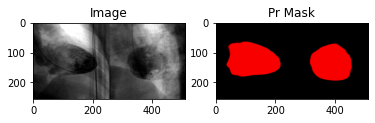

min filename: 0008600086.png


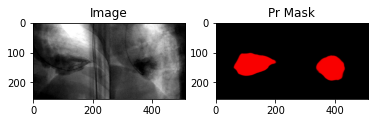

EF((EDV-ESV)/EDV): 72.0
the max area is: [15516, 16051, 15087]
the min area is: [7532, 7120, 7128]
the L of max area is: [184, 186, 176]
the L of min area is: [144, 140, 136]


In [ ]:
combine_2_images()
heart_max, max_file, max_key, heart_min, min_file, min_key, total_images, test_dict = find_max_min(skip_start=s_s, skip_end=s_e, min_threshold=min_t) # skip_start=25, skip_end=25, min_threshold=20
pr_mask_max , pr_mask_min, EF = calculate_EF(max_file, min_file, heart_max, heart_min, total_images, test_dict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:323: UserWarning: yk0015\ hypo\ 5,6_combined.png is a low contrast image


{-1: 7120, 0: 58416}
{0: 49485, 1: 16051}
{0: 56605, 1: 8931}


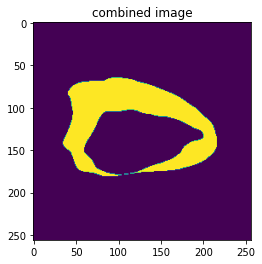

In [ ]:
make_donut(pr_mask_min, pr_mask_max, test_target)

## Lateral view donut

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:379: UserWarning: yk0015\ hypo\ 5,6_combined_l.png is a low contrast image


max_key is: 79
min_key is: 85
max filename: 0007900079.png
min filename: 0008500085.png


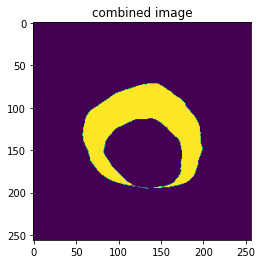

In [ ]:
# use front view max/min keys
# make_lateral_donut(max_file, min_file, test_target)

# search through every lateral view images, comment out if you want to use front view max/min keys
max_file_lateral, min_file_lateral = find_max_min_lateral(test_dict, total_images, skip_start=s_s, skip_end=s_e, min_threshold=min_t) # skip_start=25, skip_end=25, min_threshold=20
make_lateral_donut(max_file_lateral, min_file_lateral, test_target)

https://github.com/qubvel/segmentation_models